In [106]:
from keras.layers import *
from keras.regularizers import l2
from keras.optimizers import *
import numpy as np
import sklearn.model_selection
import sklearn
import h5py
import time
import keras
# import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Masking, Lambda, SpatialDropout1D, Dropout
from keras import Input, Model
# from keras.optimizer_v2.adam import Adam
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = np.load('data/dataset_smile_challenge.npy', allow_pickle=True).item()


# for training and testing data:

dataset_train = dataset['train']

dataset_test = dataset['test']


# for deep features.

deep_features = dataset_train['deep_features']

deep_features['ECG_features_C']   # conv1d backbone based features for ECG signal.

deep_features['ECG_features_T']   # transformer backbone basde features for ECG signal



# for hand-crafted features.

handcrafted_features = dataset_train['hand_crafted_features']

handcrafted_features['ECG_features']  # handcrafted features for ECG signal

handcrafted_features['GSR_features']  # handcrafted features for GSR signal.


# for labels.

labels = dataset_train['labels']  # labels.

In [3]:
# need to reshape df into 3D numpy
# helper functions to preprocess data
def encode_labels(labels):
    """
    replace label range of 0 to 6 to binary output [0: No stress, 1: Stress]

    Parameters:
        labels (numpy): List of training labels ranging 0 to 6
        
    Returns:
        encoded_labels (numpy): List of training labels ranging 0 to 1
    """
    encoded_labels = np.zeros_like(labels)
    for i in range(0, len(labels)):
        if labels[i] != 0:
            encoded_labels[i] = 1
    
    return encoded_labels

def label_binarize(labels):
    """
    replace label range of 0 to 6 to binary output [0: No stress, 1: Stress]

    Parameters:
        labels (numpy): List of training labels ranging 0 to 6
        
    Returns:
        encoded_labels (numpy): List of training labels ranging 0 to 1
    """
    labels[labels == 0] = 0
    labels[labels >= 1] = 1
    return labels


def reshape_data(x, time_steps):
    """
    Creates reshape x  to feed into NN model

    Parameters:
        x (numpy): data in 2D
        time_steps: the parameter to use as time_steps
        
    Returns:
        x_3D (numpy): numpy array of size (number_samples, time_steps, # features)
    """

    # get shape of x data
    batch_number = int(x.shape[0] / time_steps)
    features = x.shape[1]

    # shape x to 3d array
    x_3D = np.reshape(x, (batch_number, time_steps, features))

    return x_3D


def data_imputation(df):
    """
    Two pass method to impute missing data with either the next value or previous value in the column

    Parameters:
        df (df): Dataframe containing the data for a single time series set
        
    Returns:
        df (df): Dataframe with missing values/ 0 values imputed with 'bfill' and 'ffill'
    """

    df = df.replace(to_replace=0.00, method='ffill')
    df = df.replace(to_replace=0.00, method='bfill')

    return df
    
def create_imputed_dataframe(feature_array):
    # loop through each sample in training dataset
    frames = []
    for i in range(feature_array.shape[0]):

        df = pd.DataFrame(feature_array[i])
    
        df_imputation = data_imputation(df)
    
        frames.append(df_imputation)

    
    combined_df = pd.concat(frames)
    
    return combined_df

In [4]:
handcrafted_features['ECG_features'].shape[0]

2070

In [104]:
# STEP 1: Data Imputation for train and test data
# just do ECG data for this first run

# train data deep features
deep_train = dataset_train['deep_features']['ECG_features_C']
deep_test = dataset_test['deep_features']['ECG_features_C']


# train data handcrafted features
handcrafted_train_ecg = handcrafted_features['ECG_features']
handcrafted_test_ecg = dataset_test['hand_crafted_features']['ECG_features']
handcrafted_train_gsr = handcrafted_features['GSR_features']
handcrafted_test_gsr = dataset_test['hand_crafted_features']['GSR_features']


df_ecg_train = create_imputed_dataframe(handcrafted_train_ecg)
df_gsr_train = create_imputed_dataframe(handcrafted_train_gsr)
df_deep_train = create_imputed_dataframe(deep_train)

df_ecg_test = create_imputed_dataframe(handcrafted_test_ecg)
df_gsr_test = create_imputed_dataframe(handcrafted_test_gsr)
df_deep_test = create_imputed_dataframe(deep_test)

In [105]:
combined_df_train = pd.concat([df_deep_train, df_ecg_train, df_gsr_train], axis=1)
combined_df_test = pd.concat([df_deep_test, df_ecg_test, df_gsr_test], axis = 1)

In [107]:
combined_df_train

,0,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,8,9,10,11
0,0.033828,1.253795,0.262987,0.688927,0.490633,0.281133,0.501244,0.375252,0.747361,0.281257,...,0.106195,0.220779,0.020855,0.000380,0.137180,0.019145,0.699163,0.706667,0.529003,0.002153
1,0.033828,1.253795,0.262987,0.688927,0.490633,0.281133,0.501244,0.375252,0.747361,0.281257,...,0.106195,0.220779,0.020855,0.000380,0.137180,0.019145,0.699163,0.706667,0.529003,0.002153
2,0.033828,1.253795,0.262987,0.688927,0.490633,0.281133,0.501244,0.375252,0.747361,0.281257,...,0.106195,0.220779,0.020855,0.000380,0.137180,0.019145,0.699163,0.706667,0.529003,0.002153
3,0.033828,1.253795,0.262987,0.688927,0.490633,0.281133,0.501244,0.375252,0.747361,0.281257,...,0.106195,0.220779,0.020855,0.000380,0.137180,0.019145,0.699163,0.706667,0.529003,0.002153
4,0.033828,1.253795,0.262987,0.688927,0.490633,0.281133,0.501244,0.375252,0.747361,0.281257,...,0.106195,0.220779,0.020855,0.000380,0.137180,0.019145,0.699163,0.706667,0.529003,0.002153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,1.819448,1.889793,0.597544,0.571663,0.816661,0.256249,0.414682,0.299667,0.660226,0.734593,...,0.024024,0.333333,0.011771,0.029881,0.038939,0.019543,0.900186,0.885350,0.113067,0.000492
56,0.607587,2.271085,0.642423,0.704773,0.683679,0.265550,0.467894,0.383799,0.525342,0.794175,...,0.054054,0.383333,0.058085,0.033307,0.086315,0.065214,0.903320,0.885350,0.114727,0.000638
57,1.149345,2.358597,0.562871,0.642517,0.561134,0.252978,0.447775,0.342890,0.433219,0.803708,...,0.102102,0.400000,0.082916,0.050653,0.154012,0.092208,0.905798,0.891720,0.113802,0.000579
58,2.286009,2.288826,0.299204,1.074661,0.599441,0.256971,0.587522,0.369877,0.422072,0.624717,...,0.123123,0.450000,0.113003,0.053454,0.181773,0.131860,0.907618,0.891720,0.110951,0.000401


In [108]:
combined_df_test

,0,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,8,9,10,11
0,1.597891,2.648361,0.418306,0.986552,0.523547,0.287660,0.626318,0.544305,0.434723,0.913864,...,0.234234,0.533333,0.083539,1.854789e-03,0.345967,0.098900,0.873740,0.853503,0.105538,0.000587
1,1.840119,2.531563,0.535863,1.047799,0.626392,0.350704,0.662694,0.517389,0.418173,0.933059,...,0.138138,0.350000,0.036489,1.092348e-03,0.208910,0.042239,0.869968,0.850318,0.104971,0.000632
2,1.509970,2.378727,0.451662,0.911359,0.556889,0.303441,0.551851,0.421361,0.430834,0.850311,...,0.093093,0.383333,0.020759,7.507547e-04,0.146864,0.024119,0.866514,0.847134,0.106000,0.000529
3,1.641742,2.260965,0.559261,0.975424,0.605248,0.255418,0.553154,0.472105,0.375665,0.885993,...,0.066066,0.383333,0.010307,6.207377e-03,0.093006,0.011745,0.863792,0.840764,0.107693,0.000350
4,2.081508,2.374058,0.415451,1.076353,0.502316,0.293459,0.665527,0.548018,0.434134,0.835884,...,0.087087,0.366667,0.027617,9.646268e-03,0.114159,0.033706,0.862816,0.840764,0.110005,0.000227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,0.066044,1.622914,2.306570,0.950972,2.345718,0.908061,0.861908,1.246414,0.483930,1.386786,...,0.002488,0.013889,0.001737,2.732956e-08,0.002448,0.001229,0.756958,0.739394,0.122214,0.000507
56,0.066044,1.712797,1.352423,0.770469,1.421137,0.672753,0.695687,0.781364,0.609727,1.049605,...,0.002488,0.013889,0.001737,2.809106e-08,0.002448,0.001229,0.760437,0.745455,0.122208,0.000508
57,0.066044,1.783439,1.543341,0.897323,1.584063,1.020711,0.771864,1.261982,0.556308,1.050736,...,0.002488,0.013889,0.001737,1.829708e-07,0.002448,0.001229,0.764181,0.748485,0.122425,0.000531
58,0.066044,1.783439,1.543341,0.897323,1.584063,1.020711,0.771864,1.261982,0.556308,1.050736,...,0.002488,0.013889,0.001737,2.592382e-07,0.002448,0.001229,0.767509,0.751515,0.121662,0.000445


In [118]:
np_test = combined_df_test.to_numpy()
np_train = combined_df_train.to_numpy()

In [119]:
# reshape to 3D tensors
train_3D = reshape_data(np_train, time_steps = 60)
test_3D = reshape_data(np_test, time_steps = 60)

In [10]:
print(f'train shape: {train_3D.shape}')
print(f'test shape: {test_3D.shape}')

train shape: (2070, 60, 256)
test shape: (986, 60, 256)


In [11]:
# training data
esg_2d = handcrafted_features['ECG_features'].reshape(-1, handcrafted_features['ECG_features'].shape[-1])
gsr_2d = handcrafted_features['GSR_features'].reshape(-1, handcrafted_features['GSR_features'].shape[-1])

print('ESG new shape', esg_2d.shape)
print('GSR new shape', gsr_2d.shape)

handcrafted_hstack = np.hstack(( esg_2d,  gsr_2d) )

x_3d = reshape_data(handcrafted_hstack, time_steps=60)
print('x data new shape', x_3d.shape)

ESG new shape (124200, 8)
GSR new shape (124200, 12)
x data new shape (2070, 60, 20)


In [12]:
# testing data
esg_2d = dataset_test['hand_crafted_features']['ECG_features'].reshape(-1, handcrafted_features['ECG_features'].shape[-1])
gsr_2d = dataset_test['hand_crafted_features']['GSR_features'].reshape(-1, handcrafted_features['GSR_features'].shape[-1])

print('ESG new shape', esg_2d.shape)
print('GSR new shape', gsr_2d.shape)

handcrafted_hstack = np.hstack(( esg_2d,  gsr_2d) )

x_3d_test = reshape_data(handcrafted_hstack, time_steps=60)
print('x data new shape', x_3d_test.shape)

ESG new shape (59160, 8)
GSR new shape (59160, 12)
x data new shape (986, 60, 20)


In [13]:
encoded_labels = encode_labels(labels)
encoded_labels.shape

(2070,)

In [14]:
encoded_labels

array([0., 0., 0., ..., 0., 0., 1.])

In [15]:
encoded_labels.sum()

1092.0

In [129]:
## MODEL ARCHITECTURE IN KERAS ##

def CNN1D_data_comp(number_classes = 2):
  """
    Creates CNN model

    Parameters:
        number_classes (int): the number of labelled classes in dataset
    
    Returns:
        model (Keras Functional Model): Keras Functional Model
    """

  inputs = Input((60, 276))
  # inputs_b = keras.layers.BatchNormalization()(inputs)
  

  # increase filter size, batch normalization, global max vs average pooling at end, dropout, k fold

  # define convolutional layers
  # change filter size to 64 for a one layer CNN
  conv_layer_1 = keras.layers.Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', name='c1')
  conv_layer_2 = keras.layers.Conv1D(filters=1024, kernel_size=3, activation='relu', padding='same', name='c2')
  conv_layer_3 = keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', name='c3')
  conv_layer_4 = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='c4')

  # Layer 1
  c1 = conv_layer_1(inputs)

  max_pool_1 = keras.layers.MaxPool1D(pool_size=2)(c1)

  # Layer 2
  c2 = conv_layer_2(max_pool_1)
  
  max_pool_2 = keras.layers.MaxPool1D(pool_size=2)(c2)

  # Layer 3
  c3 = conv_layer_3(max_pool_2)

  max_pool_3 = keras.layers.MaxPool1D(pool_size=2)(c3)
    
  # Layer 4
  c4 = conv_layer_4(max_pool_3)
  

  

  c_last = c2
  #g1 = GlobalAvgPool1D()(c_last)
  g1 = keras.layers.GlobalMaxPooling1D()(c_last)
    
  # pre flatten shape: (2070, 30, 1024)
  # flatten = (30 * 1024) = (10,000)
  output = g1

  print(output.shape)

  output = Dense(512,activation = 'relu')(output)

  output = Dense(32,activation = 'relu')(output)

  # classification layer multiclass = softmax = [0-0.33, 0.34-0.67, 0.67-1 ]
  # 
  output = Dense(1, activation = 'sigmoid')(output)

  model = Model(inputs=inputs, outputs=output)
    
  return model

In [120]:
X, Y = train_3D, encoded_labels
time_steps = 60

In [121]:
Y.shape

(2070,)

In [122]:
'''
Notes 5/25/22:
Had issues as the conv shape of 8 was not equal to the length of 12. For the moment just combining both of them,
will tinker with it later.


Model is not learning. Tried both with and without normalization.

'''

'\nNotes 5/25/22:\nHad issues as the conv shape of 8 was not equal to the length of 12. For the moment just combining both of them,\nwill tinker with it later.\n\n\nModel is not learning. Tried both with and without normalization.\n\n'

In [123]:
train_3D[0].min()

1.915578997422697e-05

In [124]:
train_3D.shape

(2070, 60, 276)

In [125]:
train_3D.min(axis=(0,1))

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [126]:
train_3D.max(axis=(0,1))

array([3.76957607, 3.64389539, 2.99945068, 1.6964457 , 2.93444777,
       1.71279645, 1.60899997, 2.09798646, 1.56941295, 1.88238668,
       1.80075121, 1.71487808, 2.99318624, 1.59071147, 2.04539824,
       3.70977807, 4.64302921, 2.98727942, 3.48233724, 4.02101707,
       1.71913266, 1.98628664, 1.69794035, 2.82874465, 1.80882633,
       1.56452167, 1.84180427, 1.55025995, 3.50215673, 1.6264776 ,
       2.0259974 , 1.85134244, 1.52148426, 2.13701677, 2.58481383,
       1.39547849, 1.5242753 , 4.75030231, 1.54788184, 2.03651285,
       2.31177163, 3.18890023, 1.68816686, 4.49265909, 1.56311107,
       2.35206246, 1.2247448 , 1.78159475, 2.21757627, 2.13936567,
       3.74732065, 1.74939203, 1.36265802, 1.75899148, 1.99294472,
       1.46062219, 1.57905388, 2.14590931, 1.61640525, 2.32580447,
       1.63351691, 2.99952269, 1.45643163, 2.6710701 , 1.49585176,
       1.75401676, 2.59197521, 1.55569112, 3.84199691, 2.97678208,
       1.54015779, 3.04640865, 1.78347075, 1.95083046, 1.57197

In [130]:
# split into train/ test

train_x, test_x, train_y, test_y = train_test_split(train_3D, Y, test_size=0.2, shuffle=True, random_state=1)
time_steps = 60
'''
# reshape data to 2D for normalization
train_x = train_x.reshape(-1, train_x.shape[-1])
test_x = test_x.reshape(-1, test_x.shape[-1])

# normalize x based on minMax of train dataset
# create MinMax scaler
minmax = MinMaxScaler()
minmax.fit(train_x)

# normalize data based on minmax fitted on TRAINING data
norm_train_x = minmax.transform(train_x)
norm_test_x = minmax.transform(test_x)

# NOT NORM HERE
norm_train_x = train_x
norm_test_x = test_x

# reshape data back to 3D
train_x = reshape_data(norm_train_x, time_steps)
test_x = reshape_data(norm_test_x, time_steps)
'''

# load in model
cnn_model = CNN1D_data_comp()
# default learning rate: 0.001
optimizer = Adam(learning_rate = 0.001)
cnn_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
# create history callback
csv_logger = keras.callbacks.CSVLogger('cnn1D_layers512_dense51232_6_24_22_500e_training.log', separator=',', append=False)


# early_stopping
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)

# create callback to only save best epoch (highest val_accuracy)
best_epoch_filepath = "cnn1D_layers5121024_lastdense51232_6_24_22.h5"
best_epoch = keras.callbacks.ModelCheckpoint(filepath=best_epoch_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

no_epochs = 500
cnn_model.fit(train_x, train_y, epochs= no_epochs, callbacks=[csv_logger, best_epoch, es], validation_data=(test_x, test_y))


(None, 1024)
Epoch 1/500
51/52 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.4798
Epoch 1: val_accuracy improved from -inf to 0.45652, saving model to cnn1D_layers5121024_lastdense51232_6_24_22.h5
52/52 [==============================] - 2s 32ms/step - loss: nan - accuracy: 0.4807 - val_loss: nan - val_accuracy: 0.4565
Epoch 2/500
52/52 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4764
Epoch 2: val_accuracy did not improve from 0.45652
52/52 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.4764 - val_loss: nan - val_accuracy: 0.4565
Epoch 3/500
52/52 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4764
Epoch 3: val_accuracy did not improve from 0.45652
52/52 [==============================] - 1s 25ms/step - loss: nan - accuracy: 0.4764 - val_loss: nan - val_accuracy: 0.4565
Epoch 4/500
50/52 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.4800
Epoch 4: val_accuracy did not 

51/52 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.4779
Epoch 31: val_accuracy did not improve from 0.45652
52/52 [==============================] - 1s 25ms/step - loss: nan - accuracy: 0.4764 - val_loss: nan - val_accuracy: 0.4565
Epoch 32/500
52/52 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4764
Epoch 32: val_accuracy did not improve from 0.45652
52/52 [==============================] - 1s 25ms/step - loss: nan - accuracy: 0.4764 - val_loss: nan - val_accuracy: 0.4565
Epoch 33/500
50/52 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.4794
Epoch 33: val_accuracy did not improve from 0.45652
52/52 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.4764 - val_loss: nan - val_accuracy: 0.4565
Epoch 34/500
50/52 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.4775
Epoch 34: val_accuracy did not improve from 0.45652
52/52 [==============================] - 1s 26ms/step - loss:

In [ ]:
# layer params = 8 -> 16 -> 32 -> 64

# normalization val_acc = 0.64, LR = 0.0003

# no norm val_acc = 0.60, LR = 0.0003


# no norm feed forward ~0.73, LR = 0.0003 

# 1600 train, 400 test, 70 validation


In [22]:
'''
NOTES

6/15: 
Did data imputation + preprocessing on ECG handcrafted features

Repeating NN originally did not learn

Made CNN smaller, and seems to actually improve over time, though only slightly

Model predictions for both train and test all are a single number: ex .500032

Turned shuffle to false, accuracy dropped a lot within each fold

Forgot that learning rate as set really low, going to try with default rate

Tried dropout layer at the end as well, didn't seem to work

6/20:

Tried again and same issue

'''




"\nNOTES\n\n6/15: \nDid data imputation + preprocessing on ECG handcrafted features\n\nRepeating NN originally did not learn\n\nMade CNN smaller, and seems to actually improve over time, though only slightly\n\nModel predictions for both train and test all are a single number: ex .500032\n\nTurned shuffle to false, accuracy dropped a lot within each fold\n\nForgot that learning rate as set really low, going to try with default rate\n\nTried dropout layer at the end as well, didn't seem to work\n\n6/20:\n\nTried again and same issue\n\n"

In [75]:
# need to shuffle splits, as the dataset is split between healthy and unhealthy
kf = KFold(n_splits=5, shuffle=True)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
best_epochs_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kf.split(X, y=Y):
    
    # get splits
    train_x, train_y = X[train_index], Y[train_index]
    test_x, test_y = X[test_index], Y[test_index]
    
    # don't normalize for time being
    normalize = True
    if normalize:
    
        # reshape data to 2D for normalization
        train_x = train_x.reshape(-1, train_x.shape[-1])
        test_x = test_x.reshape(-1, test_x.shape[-1])

        # create MinMax scaler
        minmax = MinMaxScaler()
        minmax.fit(train_x)

        # normalize data based on minmax fitted on TRAINING data
        norm_train_x = minmax.transform(train_x)
        norm_test_x = minmax.transform(test_x)

        # reshape data back to 3D
        train_x = reshape_data(norm_train_x, time_steps)
        test_x = reshape_data(norm_test_x, time_steps)
    
    # load in model
    cnn_model = CNN1D_data_comp()
    # default learning rate: 0.001
    optimizer = Adam(learning_rate = 0.001)
    cnn_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])

    
    # create history callback
    csv_logger = keras.callbacks.CSVLogger('cnn1D_4layers8163264_dense8_6_22_22_500e_training.log', separator=',', append=False)

    # create callback to only save best epoch (highest val_accuracy)
    best_epoch_filepath = "Foldno_" + str(fold_no) + "_cnn1D_4layers8163264_lastdense8_6_22_22.h5"
    best_epoch = keras.callbacks.ModelCheckpoint(filepath=best_epoch_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    
    no_epochs = 500
    cnn_model.fit(train_x, train_y, epochs= no_epochs, callbacks=[csv_logger, best_epoch], validation_data=(test_x, test_y))
    
    # Generate generalization metrics of BEST EPOCH
    cnn_model.load_weights(best_epoch_filepath)
    scores = cnn_model.evaluate(test_x, test_y, verbose=0)
    '''
    # save results to csv file
    fit = cnn_model.predict(test_x)
    combined_np = np.hstack((test_y, fit))
    df = pd.DataFrame(combined_np, columns=['True Label', 'Prediction'])
    df.to_csv('Kfold # ' + str(fold_no) + '.csv')
    '''
    
    
    print(f'Score for fold {fold_no}: {cnn_model.metrics_names[0]} of {scores[0]}; {cnn_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  # print(f'> Fold {i+1} - Sanity Accuracy: {sanity_check_acc[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

    

(None, 64)
Epoch 1/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6937 - accuracy: 0.5167
Epoch 1: val_accuracy improved from -inf to 0.53382, saving model to Foldno_1_cnn1D_4layers8163264_lastdense8_6_22_22.h5
52/52 [==============================] - 1s 11ms/step - loss: 0.6936 - accuracy: 0.5139 - val_loss: 0.6926 - val_accuracy: 0.5338
Epoch 2/500
46/52 [=========================>....] - ETA: 0s - loss: 0.6926 - accuracy: 0.5285
Epoch 2: val_accuracy did not improve from 0.53382
52/52 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5260 - val_loss: 0.6918 - val_accuracy: 0.5338
Epoch 3/500
51/52 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5251
Epoch 3: val_accuracy did not improve from 0.53382
52/52 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5260 - val_loss: 0.6870 - val_accuracy: 0.5338
Epoch 4/500
51/52 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.526

Epoch 30/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6877 - accuracy: 0.5298
Epoch 30: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 31/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6865 - accuracy: 0.5234
Epoch 31: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6756 - val_accuracy: 0.5338
Epoch 32/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6861 - accuracy: 0.5276
Epoch 32: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6760 - val_accuracy: 0.5338
Epoch 33/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6885 - accuracy: 0.5249
Epoch 33: val_accuracy did not improve from 0.61594
52/52 [==============

Epoch 60/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6868 - accuracy: 0.5223
Epoch 60: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.5260 - val_loss: 0.6757 - val_accuracy: 0.5338
Epoch 61/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6860 - accuracy: 0.5298
Epoch 61: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6759 - val_accuracy: 0.5338
Epoch 62/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6873 - accuracy: 0.5208
Epoch 62: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6769 - val_accuracy: 0.5338
Epoch 63/500
51/52 [============================>.] - ETA: 0s - loss: 0.6872 - accuracy: 0.5239
Epoch 63: val_accuracy did not improve from 0.61594
52/52 [==============

Epoch 90/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6878 - accuracy: 0.5201
Epoch 90: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6760 - val_accuracy: 0.5338
Epoch 91/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6853 - accuracy: 0.5342
Epoch 91: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6758 - val_accuracy: 0.5338
Epoch 92/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6877 - accuracy: 0.5320
Epoch 92: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6768 - val_accuracy: 0.5338
Epoch 93/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6859 - accuracy: 0.5342
Epoch 93: val_accuracy did not improve from 0.61594
52/52 [==============

52/52 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.5260 - val_loss: 0.6772 - val_accuracy: 0.5338
Epoch 120/500
51/52 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5263
Epoch 120: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 121/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6873 - accuracy: 0.5283
Epoch 121: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6770 - val_accuracy: 0.5338
Epoch 122/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6874 - accuracy: 0.5312
Epoch 122: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6765 - val_accuracy: 0.5338
Epoch 123/500
52/52 [=============

Epoch 149/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6866 - accuracy: 0.5349
Epoch 149: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6765 - val_accuracy: 0.5338
Epoch 150/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6854 - accuracy: 0.5276
Epoch 150: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6763 - val_accuracy: 0.5338
Epoch 151/500
51/52 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5221
Epoch 151: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6765 - val_accuracy: 0.5338
Epoch 152/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6865 - accuracy: 0.5334
Epoch 152: val_accuracy did not improve from 0.61594
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 179/500
51/52 [============================>.] - ETA: 0s - loss: 0.6872 - accuracy: 0.5257
Epoch 179: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6767 - val_accuracy: 0.5338
Epoch 180/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6868 - accuracy: 0.5327
Epoch 180: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6764 - val_accuracy: 0.5338
Epoch 181/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6852 - accuracy: 0.5379
Epoch 181: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6757 - val_accuracy: 0.5338
Epoch 182/500
51/52 [=============

Epoch 208/500
52/52 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.5260
Epoch 208: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.5260 - val_loss: 0.6770 - val_accuracy: 0.5338
Epoch 209/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6873 - accuracy: 0.5225
Epoch 209: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6765 - val_accuracy: 0.5338
Epoch 210/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6889 - accuracy: 0.5156
Epoch 210: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6765 - val_accuracy: 0.5338
Epoch 211/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6880 - accuracy: 0.5231
Epoch 211: val_accuracy did not improve from 0.61594
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6759 - val_accuracy: 0.5338
Epoch 238/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6865 - accuracy: 0.5268
Epoch 238: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 239/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6853 - accuracy: 0.5262
Epoch 239: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6758 - val_accuracy: 0.5338
Epoch 240/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6881 - accuracy: 0.5320
Epoch 240: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6766 - val_accuracy: 0.5338
Epoch 241/500
44/52 [=============

Epoch 267/500
52/52 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5260
Epoch 267: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6764 - val_accuracy: 0.5338
Epoch 268/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6881 - accuracy: 0.5163
Epoch 268: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6763 - val_accuracy: 0.5338
Epoch 269/500
52/52 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5260
Epoch 269: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 270/500
52/52 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5260
Epoch 270: val_accuracy did not improve from 0.61594
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6765 - val_accuracy: 0.5338
Epoch 297/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6875 - accuracy: 0.5277
Epoch 297: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6766 - val_accuracy: 0.5338
Epoch 298/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6861 - accuracy: 0.5349
Epoch 298: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6763 - val_accuracy: 0.5338
Epoch 299/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6885 - accuracy: 0.5269
Epoch 299: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6767 - val_accuracy: 0.5338
Epoch 300/500
43/52 [=============

Epoch 326/500
52/52 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5260
Epoch 326: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6762 - val_accuracy: 0.5338
Epoch 327/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6868 - accuracy: 0.5342
Epoch 327: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6759 - val_accuracy: 0.5338
Epoch 328/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6879 - accuracy: 0.5291
Epoch 328: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6764 - val_accuracy: 0.5338
Epoch 329/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6901 - accuracy: 0.5196
Epoch 329: val_accuracy did not improve from 0.61594
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 356/500
52/52 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5260
Epoch 356: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6760 - val_accuracy: 0.5338
Epoch 357/500
51/52 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5270
Epoch 357: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6760 - val_accuracy: 0.5338
Epoch 358/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6874 - accuracy: 0.5193
Epoch 358: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6766 - val_accuracy: 0.5338
Epoch 359/500
51/52 [=============

Epoch 385/500
52/52 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5260
Epoch 385: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 386/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6869 - accuracy: 0.5246
Epoch 386: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 387/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5288
Epoch 387: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5260 - val_loss: 0.6758 - val_accuracy: 0.5338
Epoch 388/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6873 - accuracy: 0.5247
Epoch 388: val_accuracy did not improve from 0.61594
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6763 - val_accuracy: 0.5338
Epoch 415/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6882 - accuracy: 0.5276
Epoch 415: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6764 - val_accuracy: 0.5338
Epoch 416/500
52/52 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5260
Epoch 416: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6758 - val_accuracy: 0.5338
Epoch 417/500
52/52 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.5260
Epoch 417: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6763 - val_accuracy: 0.5338
Epoch 418/500
43/52 [=============

Epoch 444/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6875 - accuracy: 0.5231
Epoch 444: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 445/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6872 - accuracy: 0.5320
Epoch 445: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6762 - val_accuracy: 0.5338
Epoch 446/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6857 - accuracy: 0.5298
Epoch 446: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6758 - val_accuracy: 0.5338
Epoch 447/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6866 - accuracy: 0.5275
Epoch 447: val_accuracy did not improve from 0.61594
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6761 - val_accuracy: 0.5338
Epoch 474/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6859 - accuracy: 0.5290
Epoch 474: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5260 - val_loss: 0.6760 - val_accuracy: 0.5338
Epoch 475/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6884 - accuracy: 0.5174
Epoch 475: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6763 - val_accuracy: 0.5338
Epoch 476/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6868 - accuracy: 0.5305
Epoch 476: val_accuracy did not improve from 0.61594
52/52 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5260 - val_loss: 0.6762 - val_accuracy: 0.5338
Epoch 477/500
42/52 [=============

52/52 [==============================] - 0s 7ms/step - loss: 0.6895 - accuracy: 0.5368 - val_loss: 0.6947 - val_accuracy: 0.4903
Epoch 3/500
52/52 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5368
Epoch 3: val_accuracy did not improve from 0.49034
52/52 [==============================] - 0s 6ms/step - loss: 0.6835 - accuracy: 0.5368 - val_loss: 0.6965 - val_accuracy: 0.4903
Epoch 4/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6840 - accuracy: 0.5342
Epoch 4: val_accuracy did not improve from 0.49034
52/52 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.5368 - val_loss: 0.7005 - val_accuracy: 0.4903
Epoch 5/500
49/52 [===========================>..] - ETA: 0s - loss: 0.6803 - accuracy: 0.5364
Epoch 5: val_accuracy did not improve from 0.49034
52/52 [==============================] - 0s 7ms/step - loss: 0.6808 - accuracy: 0.5368 - val_loss: 0.6956 - val_accuracy: 0.4903
Epoch 6/500
51/52 [===========================

Epoch 31/500
51/52 [============================>.] - ETA: 0s - loss: 0.6438 - accuracy: 0.6158
Epoch 31: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.6427 - accuracy: 0.6184 - val_loss: 0.6807 - val_accuracy: 0.5821
Epoch 32/500
52/52 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6111
Epoch 32: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.6461 - accuracy: 0.6111 - val_loss: 0.6813 - val_accuracy: 0.5725
Epoch 33/500
52/52 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.6099
Epoch 33: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.6423 - accuracy: 0.6099 - val_loss: 0.6852 - val_accuracy: 0.5894
Epoch 34/500
49/52 [===========================>..] - ETA: 0s - loss: 0.6350 - accuracy: 0.6250
Epoch 34: val_accuracy did not improve from 0.59179
52/52 [==============

Epoch 61/500
44/52 [========================>.....] - ETA: 0s - loss: 0.4852 - accuracy: 0.7628
Epoch 61: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.4911 - accuracy: 0.7585 - val_loss: 0.9471 - val_accuracy: 0.5266
Epoch 62/500
52/52 [==============================] - ETA: 0s - loss: 0.4755 - accuracy: 0.7796
Epoch 62: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.4755 - accuracy: 0.7796 - val_loss: 0.8933 - val_accuracy: 0.5266
Epoch 63/500
52/52 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.7627
Epoch 63: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.4822 - accuracy: 0.7627 - val_loss: 0.9124 - val_accuracy: 0.5435
Epoch 64/500
44/52 [========================>.....] - ETA: 0s - loss: 0.4783 - accuracy: 0.7607
Epoch 64: val_accuracy did not improve from 0.59179
52/52 [==============

Epoch 91/500
43/52 [=======================>......] - ETA: 0s - loss: 0.2608 - accuracy: 0.8961
Epoch 91: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.2623 - accuracy: 0.8925 - val_loss: 1.3279 - val_accuracy: 0.5580
Epoch 92/500
43/52 [=======================>......] - ETA: 0s - loss: 0.2494 - accuracy: 0.8953
Epoch 92: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.2547 - accuracy: 0.8919 - val_loss: 1.3998 - val_accuracy: 0.5531
Epoch 93/500
43/52 [=======================>......] - ETA: 0s - loss: 0.2403 - accuracy: 0.9070
Epoch 93: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.2474 - accuracy: 0.9040 - val_loss: 1.4523 - val_accuracy: 0.5507
Epoch 94/500
51/52 [============================>.] - ETA: 0s - loss: 0.2431 - accuracy: 0.9020
Epoch 94: val_accuracy did not improve from 0.59179
52/52 [==============

52/52 [==============================] - 0s 6ms/step - loss: 0.1294 - accuracy: 0.9535 - val_loss: 2.1387 - val_accuracy: 0.5556
Epoch 121/500
42/52 [=======================>......] - ETA: 0s - loss: 0.1160 - accuracy: 0.9583
Epoch 121: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.1187 - accuracy: 0.9565 - val_loss: 2.2284 - val_accuracy: 0.5386
Epoch 122/500
42/52 [=======================>......] - ETA: 0s - loss: 0.1158 - accuracy: 0.9598
Epoch 122: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.1181 - accuracy: 0.9589 - val_loss: 2.2124 - val_accuracy: 0.5531
Epoch 123/500
42/52 [=======================>......] - ETA: 0s - loss: 0.1072 - accuracy: 0.9650
Epoch 123: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.1112 - accuracy: 0.9620 - val_loss: 2.2481 - val_accuracy: 0.5507
Epoch 124/500
52/52 [=============

Epoch 150/500
50/52 [===========================>..] - ETA: 0s - loss: 0.0777 - accuracy: 0.9737
Epoch 150: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0776 - accuracy: 0.9740 - val_loss: 2.6911 - val_accuracy: 0.5483
Epoch 151/500
52/52 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9734
Epoch 151: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0765 - accuracy: 0.9734 - val_loss: 2.6870 - val_accuracy: 0.5314
Epoch 152/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0729 - accuracy: 0.9731
Epoch 152: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0723 - accuracy: 0.9740 - val_loss: 2.7867 - val_accuracy: 0.5531
Epoch 153/500
49/52 [===========================>..] - ETA: 0s - loss: 0.0715 - accuracy: 0.9732
Epoch 153: val_accuracy did not improve from 0.59179
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.9740 - val_loss: 3.7951 - val_accuracy: 0.5411
Epoch 180/500
52/52 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9740
Epoch 180: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0613 - accuracy: 0.9740 - val_loss: 3.8083 - val_accuracy: 0.5459
Epoch 181/500
52/52 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9740
Epoch 181: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0608 - accuracy: 0.9740 - val_loss: 3.8375 - val_accuracy: 0.5362
Epoch 182/500
52/52 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9740
Epoch 182: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 0.9740 - val_loss: 3.8304 - val_accuracy: 0.5362
Epoch 183/500
43/52 [=============

Epoch 209/500
51/52 [============================>.] - ETA: 0s - loss: 0.0583 - accuracy: 0.9749
Epoch 209: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0585 - accuracy: 0.9746 - val_loss: 4.5967 - val_accuracy: 0.5411
Epoch 210/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0568 - accuracy: 0.9753
Epoch 210: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0578 - accuracy: 0.9746 - val_loss: 4.6291 - val_accuracy: 0.5411
Epoch 211/500
44/52 [========================>.....] - ETA: 0s - loss: 0.0608 - accuracy: 0.9723
Epoch 211: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0585 - accuracy: 0.9746 - val_loss: 4.6333 - val_accuracy: 0.5362
Epoch 212/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6487 - accuracy: 0.8525
Epoch 212: val_accuracy did not improve from 0.59179
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.0582 - accuracy: 0.9746 - val_loss: 3.9372 - val_accuracy: 0.5483
Epoch 239/500
52/52 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9746
Epoch 239: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0585 - accuracy: 0.9746 - val_loss: 3.9743 - val_accuracy: 0.5507
Epoch 240/500
51/52 [============================>.] - ETA: 0s - loss: 0.0585 - accuracy: 0.9743
Epoch 240: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0580 - accuracy: 0.9746 - val_loss: 3.9916 - val_accuracy: 0.5531
Epoch 241/500
52/52 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9746
Epoch 241: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0586 - accuracy: 0.9746 - val_loss: 4.0228 - val_accuracy: 0.5459
Epoch 242/500
43/52 [=============

Epoch 268/500
42/52 [=======================>......] - ETA: 0s - loss: 0.0561 - accuracy: 0.9762
Epoch 268: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0587 - accuracy: 0.9746 - val_loss: 3.5640 - val_accuracy: 0.5531
Epoch 269/500
52/52 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9746
Epoch 269: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0591 - accuracy: 0.9746 - val_loss: 3.5876 - val_accuracy: 0.5556
Epoch 270/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0615 - accuracy: 0.9731
Epoch 270: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0586 - accuracy: 0.9746 - val_loss: 3.6288 - val_accuracy: 0.5531
Epoch 271/500
51/52 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9743
Epoch 271: val_accuracy did not improve from 0.59179
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.0579 - accuracy: 0.9746 - val_loss: 4.2971 - val_accuracy: 0.5483
Epoch 298/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0645 - accuracy: 0.9695
Epoch 298: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0573 - accuracy: 0.9746 - val_loss: 4.2707 - val_accuracy: 0.5531
Epoch 299/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0549 - accuracy: 0.9760
Epoch 299: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0572 - accuracy: 0.9746 - val_loss: 4.3725 - val_accuracy: 0.5459
Epoch 300/500
50/52 [===========================>..] - ETA: 0s - loss: 0.0574 - accuracy: 0.9744
Epoch 300: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0569 - accuracy: 0.9746 - val_loss: 4.3739 - val_accuracy: 0.5556
Epoch 301/500
42/52 [=============

Epoch 327/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6191 - accuracy: 0.6592
Epoch 327: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.6104 - accuracy: 0.6661 - val_loss: 0.9591 - val_accuracy: 0.4976
Epoch 328/500
49/52 [===========================>..] - ETA: 0s - loss: 0.3641 - accuracy: 0.8386
Epoch 328: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 7ms/step - loss: 0.3606 - accuracy: 0.8412 - val_loss: 1.4669 - val_accuracy: 0.5411
Epoch 329/500
42/52 [=======================>......] - ETA: 0s - loss: 0.2234 - accuracy: 0.9115
Epoch 329: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.2054 - accuracy: 0.9215 - val_loss: 1.9324 - val_accuracy: 0.5362
Epoch 330/500
42/52 [=======================>......] - ETA: 0s - loss: 0.2194 - accuracy: 0.9085
Epoch 330: val_accuracy did not improve from 0.59179
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.0571 - accuracy: 0.9746 - val_loss: 4.0097 - val_accuracy: 0.5411
Epoch 357/500
42/52 [=======================>......] - ETA: 0s - loss: 0.0561 - accuracy: 0.9754
Epoch 357: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0570 - accuracy: 0.9746 - val_loss: 4.0253 - val_accuracy: 0.5459
Epoch 358/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0522 - accuracy: 0.9782
Epoch 358: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0571 - accuracy: 0.9746 - val_loss: 4.0595 - val_accuracy: 0.5411
Epoch 359/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0554 - accuracy: 0.9760
Epoch 359: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0571 - accuracy: 0.9746 - val_loss: 4.0816 - val_accuracy: 0.5435
Epoch 360/500
52/52 [=============

Epoch 386/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0593 - accuracy: 0.9731
Epoch 386: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0564 - accuracy: 0.9746 - val_loss: 4.6580 - val_accuracy: 0.5507
Epoch 387/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0532 - accuracy: 0.9767
Epoch 387: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0563 - accuracy: 0.9746 - val_loss: 4.6944 - val_accuracy: 0.5459
Epoch 388/500
52/52 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9746
Epoch 388: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0564 - accuracy: 0.9746 - val_loss: 4.6910 - val_accuracy: 0.5459
Epoch 389/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0578 - accuracy: 0.9731
Epoch 389: val_accuracy did not improve from 0.59179
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.0571 - accuracy: 0.9746 - val_loss: 3.7933 - val_accuracy: 0.5531
Epoch 416/500
52/52 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9746
Epoch 416: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0570 - accuracy: 0.9746 - val_loss: 3.8387 - val_accuracy: 0.5483
Epoch 417/500
44/52 [========================>.....] - ETA: 0s - loss: 0.0569 - accuracy: 0.9744
Epoch 417: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0570 - accuracy: 0.9746 - val_loss: 3.8820 - val_accuracy: 0.5362
Epoch 418/500
49/52 [===========================>..] - ETA: 0s - loss: 0.0577 - accuracy: 0.9739
Epoch 418: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 7ms/step - loss: 0.0574 - accuracy: 0.9746 - val_loss: 3.8903 - val_accuracy: 0.5507
Epoch 419/500
52/52 [=============

Epoch 445/500
52/52 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9746
Epoch 445: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0567 - accuracy: 0.9746 - val_loss: 4.4210 - val_accuracy: 0.5435
Epoch 446/500
51/52 [============================>.] - ETA: 0s - loss: 0.0575 - accuracy: 0.9743
Epoch 446: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0567 - accuracy: 0.9746 - val_loss: 4.4571 - val_accuracy: 0.5362
Epoch 447/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0573 - accuracy: 0.9746
Epoch 447: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0565 - accuracy: 0.9746 - val_loss: 4.4835 - val_accuracy: 0.5386
Epoch 448/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0575 - accuracy: 0.9738
Epoch 448: val_accuracy did not improve from 0.59179
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.0564 - accuracy: 0.9746 - val_loss: 4.8972 - val_accuracy: 0.5459
Epoch 475/500
43/52 [=======================>......] - ETA: 0s - loss: 0.0552 - accuracy: 0.9753
Epoch 475: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0562 - accuracy: 0.9746 - val_loss: 4.9286 - val_accuracy: 0.5411
Epoch 476/500
52/52 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9746
Epoch 476: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0562 - accuracy: 0.9746 - val_loss: 4.9557 - val_accuracy: 0.5386
Epoch 477/500
52/52 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9746
Epoch 477: val_accuracy did not improve from 0.59179
52/52 [==============================] - 0s 6ms/step - loss: 0.0563 - accuracy: 0.9746 - val_loss: 4.9453 - val_accuracy: 0.5386
Epoch 478/500
42/52 [=============

52/52 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.5248 - val_loss: 0.6828 - val_accuracy: 0.5386
Epoch 4/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5250
Epoch 4: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 7ms/step - loss: 0.6855 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 5/500
51/52 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5233
Epoch 5: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 7ms/step - loss: 0.6864 - accuracy: 0.5248 - val_loss: 0.6829 - val_accuracy: 0.5386
Epoch 6/500
51/52 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5239
Epoch 6: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 7ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 7/500
50/52 [===========================

Epoch 63/500
52/52 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5248
Epoch 63: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 64/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6845 - accuracy: 0.5298
Epoch 64: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 65/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6859 - accuracy: 0.5365
Epoch 65: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 66/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6855 - accuracy: 0.5206
Epoch 66: val_accuracy did not improve from 0.53865
52/52 [==============

Epoch 93/500
51/52 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5233
Epoch 93: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 94/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6877 - accuracy: 0.5225
Epoch 94: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 95/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 95: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 96/500
51/52 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5263
Epoch 96: val_accuracy did not improve from 0.53865
52/52 [==============

52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 123/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 123: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 124/500
52/52 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5248
Epoch 124: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 125/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5244
Epoch 125: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6826 - val_accuracy: 0.5386
Epoch 126/500
51/52 [=============

Epoch 152/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5244
Epoch 152: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 153/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6858 - accuracy: 0.5283
Epoch 153: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 154/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 154: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 155/500
51/52 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5239
Epoch 155: val_accuracy did not improve from 0.53865
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 182/500
51/52 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.5239
Epoch 182: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 183/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6848 - accuracy: 0.5269
Epoch 183: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 184/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6835 - accuracy: 0.5223
Epoch 184: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 185/500
42/52 [=============

Epoch 211/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6848 - accuracy: 0.5312
Epoch 211: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 212/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6856 - accuracy: 0.5179
Epoch 212: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 213/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 213: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 214/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5225
Epoch 214: val_accuracy did not improve from 0.53865
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 241/500
51/52 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5233
Epoch 241: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 242/500
52/52 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5248
Epoch 242: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 243/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6840 - accuracy: 0.5208
Epoch 243: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 244/500
52/52 [=============

Epoch 270/500
52/52 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5248
Epoch 270: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 271/500
51/52 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5233
Epoch 271: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 272/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6857 - accuracy: 0.5305
Epoch 272: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 273/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 273: val_accuracy did not improve from 0.53865
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 300/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5294
Epoch 300: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 301/500
51/52 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.5221
Epoch 301: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 302/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6861 - accuracy: 0.5233
Epoch 302: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 303/500
52/52 [=============

Epoch 329/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 329: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 330/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6845 - accuracy: 0.5208
Epoch 330: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 331/500
51/52 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5263
Epoch 331: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 332/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6864 - accuracy: 0.5275
Epoch 332: val_accuracy did not improve from 0.53865
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 359/500
52/52 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5248
Epoch 359: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 360/500
51/52 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5251
Epoch 360: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 361/500
52/52 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5248
Epoch 361: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 362/500
50/52 [=============

Epoch 388/500
51/52 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5263
Epoch 388: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 389/500
52/52 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5248
Epoch 389: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 7ms/step - loss: 0.6854 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 390/500
52/52 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5248
Epoch 390: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 391/500
52/52 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5248
Epoch 391: val_accuracy did not improve from 0.53865
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 418/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6826 - accuracy: 0.5348
Epoch 418: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 419/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 419: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 420/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6860 - accuracy: 0.5298
Epoch 420: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 421/500
51/52 [=============

Epoch 447/500
51/52 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5196
Epoch 447: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 448/500
47/52 [==========================>...] - ETA: 0s - loss: 0.6856 - accuracy: 0.5226
Epoch 448: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 7ms/step - loss: 0.6855 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 449/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 449: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 450/500
51/52 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5227
Epoch 450: val_accuracy did not improve from 0.53865
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 477/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5248
Epoch 477: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6824 - val_accuracy: 0.5386
Epoch 478/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6869 - accuracy: 0.5126
Epoch 478: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 479/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6838 - accuracy: 0.5233
Epoch 479: val_accuracy did not improve from 0.53865
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5248 - val_loss: 0.6825 - val_accuracy: 0.5386
Epoch 480/500
52/52 [=============

Epoch 35/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6840 - accuracy: 0.5231
Epoch 35: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6832 - val_accuracy: 0.5531
Epoch 36/500
52/52 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5211
Epoch 36: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5211 - val_loss: 0.6836 - val_accuracy: 0.5531
Epoch 37/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6869 - accuracy: 0.5193
Epoch 37: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.5211 - val_loss: 0.6838 - val_accuracy: 0.5531
Epoch 38/500
52/52 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5211
Epoch 38: val_accuracy did not improve from 0.55314
52/52 [==============

Epoch 65/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5211
Epoch 65: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 66/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6856 - accuracy: 0.5196
Epoch 66: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6850 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 67/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6847 - accuracy: 0.5193
Epoch 67: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 68/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6862 - accuracy: 0.5193
Epoch 68: val_accuracy did not improve from 0.55314
52/52 [==============

Epoch 95/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6863 - accuracy: 0.5067
Epoch 95: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5139 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 96/500
52/52 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5115
Epoch 96: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 7ms/step - loss: 0.6856 - accuracy: 0.5115 - val_loss: 0.6836 - val_accuracy: 0.5531
Epoch 97/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6867 - accuracy: 0.5276
Epoch 97: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 98/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6851 - accuracy: 0.5238
Epoch 98: val_accuracy did not improve from 0.55314
52/52 [==============

52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 125/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6852 - accuracy: 0.5167
Epoch 125: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6836 - val_accuracy: 0.5531
Epoch 126/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6851 - accuracy: 0.5238
Epoch 126: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 127/500
52/52 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5211
Epoch 127: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 128/500
42/52 [=============

Epoch 154/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.5206
Epoch 154: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6831 - val_accuracy: 0.5531
Epoch 155/500
52/52 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5211
Epoch 155: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 156/500
52/52 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5211
Epoch 156: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 157/500
51/52 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5227
Epoch 157: val_accuracy did not improve from 0.55314
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 184/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5238
Epoch 184: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 7ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 185/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6832 - accuracy: 0.5134
Epoch 185: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6832 - val_accuracy: 0.5531
Epoch 186/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6833 - accuracy: 0.5320
Epoch 186: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 187/500
42/52 [=============

Epoch 213/500
51/52 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5214
Epoch 213: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5211 - val_loss: 0.6832 - val_accuracy: 0.5531
Epoch 214/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6835 - accuracy: 0.5240
Epoch 214: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6832 - val_accuracy: 0.5531
Epoch 215/500
52/52 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5211
Epoch 215: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 216/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6824 - accuracy: 0.5268
Epoch 216: val_accuracy did not improve from 0.55314
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 243/500
52/52 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5211
Epoch 243: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 244/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6856 - accuracy: 0.5163
Epoch 244: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 245/500
52/52 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5211
Epoch 245: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 246/500
42/52 [=============

Epoch 272/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6854 - accuracy: 0.5312
Epoch 272: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 273/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6844 - accuracy: 0.5312
Epoch 273: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 274/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6858 - accuracy: 0.5194
Epoch 274: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 7ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 275/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6855 - accuracy: 0.5167
Epoch 275: val_accuracy did not improve from 0.55314
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 302/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5211
Epoch 302: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 303/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6806 - accuracy: 0.5290
Epoch 303: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 304/500
52/52 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5211
Epoch 304: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 305/500
42/52 [=============

Epoch 331/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5211
Epoch 331: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6832 - val_accuracy: 0.5531
Epoch 332/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6856 - accuracy: 0.5223
Epoch 332: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 333/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6840 - accuracy: 0.5244
Epoch 333: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 334/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5211
Epoch 334: val_accuracy did not improve from 0.55314
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5531
Epoch 361/500
52/52 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5211
Epoch 361: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 362/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6863 - accuracy: 0.5097
Epoch 362: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 363/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6867 - accuracy: 0.5231
Epoch 363: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 364/500
50/52 [=============

Epoch 390/500
52/52 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5211
Epoch 390: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 391/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6844 - accuracy: 0.5179
Epoch 391: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 392/500
52/52 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5211
Epoch 392: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 393/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6867 - accuracy: 0.5135
Epoch 393: val_accuracy did not improve from 0.55314
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 420/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6856 - accuracy: 0.5233
Epoch 420: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 421/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6824 - accuracy: 0.5160
Epoch 421: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 422/500
51/52 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5202
Epoch 422: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 423/500
51/52 [=============

Epoch 449/500
52/52 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5211
Epoch 449: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6850 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 450/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6861 - accuracy: 0.4898
Epoch 450: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.4952 - val_loss: 0.6832 - val_accuracy: 0.5531
Epoch 451/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6872 - accuracy: 0.5156
Epoch 451: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 452/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6846 - accuracy: 0.5246
Epoch 452: val_accuracy did not improve from 0.55314
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5531
Epoch 479/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6836 - accuracy: 0.5234
Epoch 479: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 480/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6836 - accuracy: 0.5379
Epoch 480: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5211 - val_loss: 0.6832 - val_accuracy: 0.5531
Epoch 481/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6842 - accuracy: 0.5234
Epoch 481: val_accuracy did not improve from 0.55314
52/52 [==============================] - 0s 6ms/step - loss: 0.6850 - accuracy: 0.5211 - val_loss: 0.6834 - val_accuracy: 0.5531
Epoch 482/500
52/52 [=============

52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6866 - val_accuracy: 0.5217
Epoch 8/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6824 - accuracy: 0.5283
Epoch 8: val_accuracy did not improve from 0.52174
52/52 [==============================] - 0s 6ms/step - loss: 0.6836 - accuracy: 0.5290 - val_loss: 0.6860 - val_accuracy: 0.5217
Epoch 9/500
52/52 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.5290
Epoch 9: val_accuracy did not improve from 0.52174
52/52 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5290 - val_loss: 0.6851 - val_accuracy: 0.5217
Epoch 10/500
52/52 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.5332
Epoch 10: val_accuracy improved from 0.52174 to 0.52899, saving model to Foldno_5_cnn1D_4layers8163264_lastdense8_6_22_22.h5
52/52 [==============================] - 0s 7ms/step - loss: 0.6803 - accuracy: 0.5332 - val_loss: 0

Epoch 37/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6836 - accuracy: 0.5276
Epoch 37: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6871 - val_accuracy: 0.5217
Epoch 38/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6833 - accuracy: 0.5268
Epoch 38: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 39/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5312
Epoch 39: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 40/500
51/52 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5288
Epoch 40: val_accuracy did not improve from 0.52899
52/52 [==============

Epoch 67/500
52/52 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5290
Epoch 67: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 68/500
51/52 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5294
Epoch 68: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 69/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6850 - accuracy: 0.5253
Epoch 69: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 70/500
52/52 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5290
Epoch 70: val_accuracy did not improve from 0.52899
52/52 [==============

Epoch 97/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6830 - accuracy: 0.5283
Epoch 97: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 98/500
52/52 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5290
Epoch 98: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 99/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6829 - accuracy: 0.5327
Epoch 99: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 100/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6815 - accuracy: 0.5392
Epoch 100: val_accuracy did not improve from 0.52899
52/52 [============

52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 127/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6836 - accuracy: 0.5283
Epoch 127: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 128/500
49/52 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.5274
Epoch 128: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 7ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 129/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6844 - accuracy: 0.5350
Epoch 129: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 130/500
43/52 [=============

Epoch 156/500
52/52 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5290
Epoch 156: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 157/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6849 - accuracy: 0.5298
Epoch 157: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6840 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 158/500
52/52 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5290
Epoch 158: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 159/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6843 - accuracy: 0.5341
Epoch 159: val_accuracy did not improve from 0.52899
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 186/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5263
Epoch 186: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 187/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6826 - accuracy: 0.5365
Epoch 187: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 188/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6856 - accuracy: 0.5283
Epoch 188: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 189/500
42/52 [=============

Epoch 215/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6836 - accuracy: 0.5305
Epoch 215: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 216/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6863 - accuracy: 0.5269
Epoch 216: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 217/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6849 - accuracy: 0.5320
Epoch 217: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 218/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6810 - accuracy: 0.5417
Epoch 218: val_accuracy did not improve from 0.52899
52/52 [======

52/52 [==============================] - 0s 7ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 245/500
51/52 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5288
Epoch 245: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 246/500
52/52 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5290
Epoch 246: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 247/500
51/52 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5276
Epoch 247: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 7ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 248/500
51/52 [=============

Epoch 274/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5288
Epoch 274: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 7ms/step - loss: 0.6844 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 275/500
52/52 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5290
Epoch 275: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 276/500
52/52 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5290
Epoch 276: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 277/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6842 - accuracy: 0.5220
Epoch 277: val_accuracy did not improve from 0.52899
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 304/500
52/52 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5290
Epoch 304: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 305/500
52/52 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5290
Epoch 305: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 306/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6806 - accuracy: 0.5312
Epoch 306: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 307/500
52/52 [=============

Epoch 333/500
51/52 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5325
Epoch 333: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 334/500
52/52 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5290
Epoch 334: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 335/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6855 - accuracy: 0.5291
Epoch 335: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 336/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6844 - accuracy: 0.5334
Epoch 336: val_accuracy did not improve from 0.52899
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 363/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6842 - accuracy: 0.5254
Epoch 363: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 364/500
51/52 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5319
Epoch 364: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 365/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6799 - accuracy: 0.5365
Epoch 365: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6871 - val_accuracy: 0.5217
Epoch 366/500
42/52 [=============

Epoch 392/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6861 - accuracy: 0.5223
Epoch 392: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 393/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6821 - accuracy: 0.5334
Epoch 393: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 394/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6828 - accuracy: 0.5371
Epoch 394: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6840 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 395/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6846 - accuracy: 0.5260
Epoch 395: val_accuracy did not improve from 0.52899
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 422/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6860 - accuracy: 0.5312
Epoch 422: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 423/500
52/52 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5290
Epoch 423: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 424/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6817 - accuracy: 0.5238
Epoch 424: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 425/500
42/52 [=============

Epoch 451/500
50/52 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5319
Epoch 451: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 7ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 452/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6817 - accuracy: 0.5305
Epoch 452: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6870 - val_accuracy: 0.5217
Epoch 453/500
42/52 [=======================>......] - ETA: 0s - loss: 0.6831 - accuracy: 0.5260
Epoch 453: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 454/500
43/52 [=======================>......] - ETA: 0s - loss: 0.6860 - accuracy: 0.5378
Epoch 454: val_accuracy did not improve from 0.52899
52/52 [======

52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 481/500
52/52 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5290
Epoch 481: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 482/500
52/52 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5290
Epoch 482: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5290 - val_loss: 0.6868 - val_accuracy: 0.5217
Epoch 483/500
44/52 [========================>.....] - ETA: 0s - loss: 0.6839 - accuracy: 0.5291
Epoch 483: val_accuracy did not improve from 0.52899
52/52 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5290 - val_loss: 0.6869 - val_accuracy: 0.5217
Epoch 484/500
52/52 [=============

In [ ]:
# after k fold, train model with a general train test split



In [91]:
# now predict y values with model
train_x = train_3D
test_x = test_3D
time_steps = 60

# load in model
cnn_model = CNN1D_data_comp()
# default learning rate: 0.001
optimizer = Adam(learning_rate = 0.001)
cnn_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])

best_epoch_filepath = "cnn1D_layers5121024_lastdense51232_6_24_22.h5"
# Generate generalization metrics of BEST EPOCH
cnn_model.load_weights(best_epoch_filepath)

Y_test_pred = cnn_model.predict(test_x)

(None, 1024)
31/31 [==============================] - 0s 8ms/step


In [92]:
cnn_model.evaluate(train_x, Y, verbose=1)

65/65 [==============================] - 1s 8ms/step - loss: 0.5576 - accuracy: 0.7130


[0.557625949382782, 0.7130434513092041]

In [93]:
np.set_printoptions(threshold=np.inf)

In [94]:
Y_test_pred

array([[0.6405927 ],
       [0.55741   ],
       [0.64368206],
       [0.49377197],
       [0.7578418 ],
       [0.74756664],
       [0.48245376],
       [0.64678454],
       [0.5811455 ],
       [0.52970433],
       [0.54596233],
       [0.45697576],
       [0.4893165 ],
       [0.55075026],
       [0.5244856 ],
       [0.61196727],
       [0.5293193 ],
       [0.60022897],
       [0.6716684 ],
       [0.70801985],
       [0.52141666],
       [0.67752457],
       [0.8064878 ],
       [0.8862688 ],
       [0.443663  ],
       [0.55055684],
       [0.6545065 ],
       [0.5641987 ],
       [0.54033285],
       [0.5796676 ],
       [0.4665423 ],
       [0.62644035],
       [0.54469603],
       [0.5330341 ],
       [0.5038008 ],
       [0.45642695],
       [0.49202305],
       [0.48812944],
       [0.56063944],
       [0.57486176],
       [0.56303906],
       [0.63175327],
       [0.59644693],
       [0.60669667],
       [0.6211319 ],
       [0.58587044],
       [0.6142567 ],
       [0.530

In [95]:
Y_test_pred.min()

0.0018193898

In [96]:
yhat = Y_test_pred.copy()

yhat[yhat >= .5] = 1
yhat[yhat < .5] = 0

In [97]:
yhat

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],

In [98]:
yhat.sum() / 986

0.6308316430020284

In [85]:
1 - yhat.sum()/ 986

0.5446247464503042

In [99]:
# write a list to a text file
def list_to_file(lst, file_name):
    with open(file_name, 'w') as f:
        for item in lst:
            f.write("%d\n" % item)

In [100]:
list_to_file(yhat, 'answer.txt')

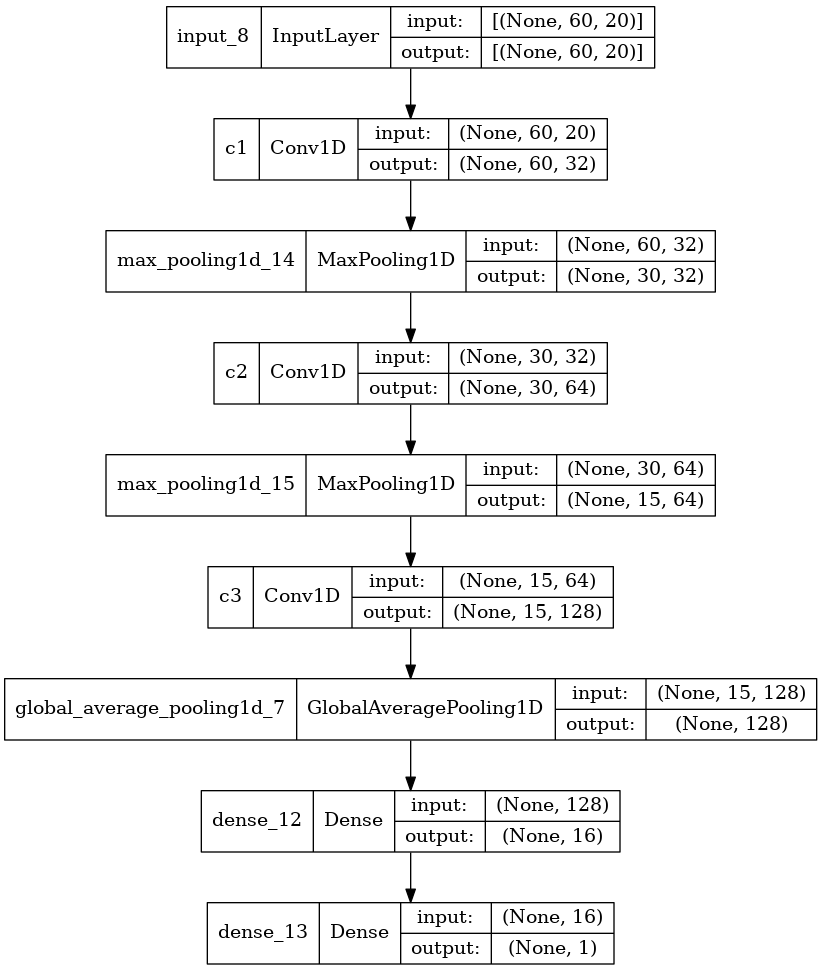

In [31]:
from keras.utils.vis_utils import plot_model

plot_model(cnn_model, to_file='model_plot_5_25_22e.png', show_shapes=True, show_layer_names=True)

In [88]:
cnn_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 60, 256)]         0         
                                                                 
 c1 (Conv1D)                 (None, 60, 512)           393728    
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 30, 512)          0         
 g1D)                                                            
                                                                 
 c2 (Conv1D)                 (None, 30, 1024)          1573888   
                                                                 
 global_average_pooling1d_9   (None, 1024)             0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_27 (Dense)            (None, 512)               5248

In [55]:
training_log = pd.read_csv('cnn1D_dropout_3layers163264_6_20_22_500e_training.log')

In [56]:
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.533213,0.692674,0.504831,0.693103
1,1,0.533213,0.692512,0.504831,0.693110
2,2,0.533213,0.692148,0.504831,0.693188
3,3,0.533213,0.691858,0.504831,0.693258
4,4,0.533213,0.691619,0.504831,0.693372
...,...,...,...,...,...
995,995,0.533213,0.690976,0.504831,0.694690
996,996,0.533213,0.690969,0.504831,0.694718
997,997,0.533213,0.690959,0.504831,0.694760
998,998,0.533213,0.690968,0.504831,0.694736


In [43]:
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/users/PAS2022/rf15/.conda/envs/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


AttributeError: module 'matplotlib' has no attribute 'figure'

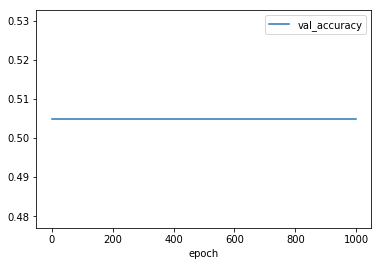

In [57]:
training_log.plot(x="epoch", y="val_accuracy")

/users/PAS2022/rf15/.conda/envs/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/users/PAS2022/rf15/.conda/envs/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/users/PAS2022/rf15/.conda/envs/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


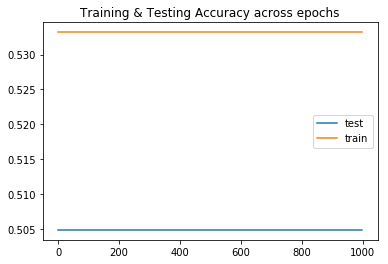

In [58]:
# plot lines
plt.plot(training_log['epoch'], training_log['val_accuracy'], label = "test")
plt.plot(training_log['epoch'], training_log['accuracy'], label = "train")
plt.title('Training & Testing Accuracy across epochs')
plt.legend()
plt.show()

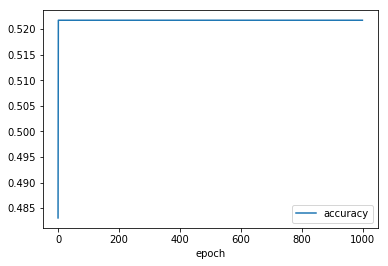

In [46]:
training_log.plot(x="epoch", y="accuracy")